## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

In [49]:
import os
import cv2
import numpy as np

In [8]:
trainPathsList = []

dirPath = "./data/kaggle_dogcat/train/dogs"
for fileName in os.listdir(dirPath):
    filePath = os.path.join(dirPath, fileName)
    trainPathsList.append(filePath)
    
dirPath = "./data/kaggle_dogcat/train/cats"
for fileName in os.listdir(dirPath):
    filePath = os.path.join(dirPath, fileName)
    trainPathsList.append(filePath)

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt

inputH = 128
inputW = 128

x_train = np.zeros([len(trainPathsList),inputH,inputW,3], np.float32)

for idx, trainPath in enumerate(trainPathsList[104:]):
    img = cv2.imread(trainPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imgH, imgW = img.shape[0:2]
    imgS = imgH if imgH > imgW else imgW
    padH = imgS - imgH
    padW = imgS - imgW
    img = cv2.copyMakeBorder(img,padH//2,padH//2,padW//2,padW//2,cv2.BORDER_CONSTANT)
    
    img = cv2.resize(img, (inputW, inputH))
    x_train[idx] = img / 255.

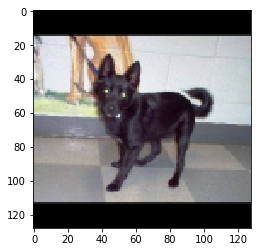

In [70]:
plt.imshow(x_train[5])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

exp = 6

def mynet_block(inputs,
                num_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                name='MB'):
    
    in_filters = inputs.get_shape()[-1]
    x = inputs
    if strides==1 and in_filters==num_filters:
        # head
        x = Conv2D(num_filters*exp, 1, 1, padding='same', 
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4), name=name+'/conv_head') (x)
        x = BatchNormalization(name=name+'/bn_head')(x)
        x = Activation(activation, name=name+'/act_head')(x)
        # mid
        x = keras.layers.DepthwiseConv2D(kernel_size, padding='same', name=name+'/conv') (x)
        """
        x = Conv2D(num_filters*2,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4), name=name+'/conv')(x)
        """
        x = BatchNormalization(name=name+'/bn')(x)
        x = Activation(activation, name=name+'/act')(x)
        # tail
        x = Conv2D(num_filters, 1, 1, padding='same', 
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4), name=name+'/conv_tail') (x)
        x = BatchNormalization(name=name+'/bn_tail')(x)
        x = Add(name=name+'/add')([x, inputs])
    else:
        x = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4), name=name+'/conv')(x)
        x = BatchNormalization(name=name+'/bn')(x)
        x = Activation(activation, name=name+'/act')(x)
    return x

In [ ]:
num_classes = 10
input_shape = [32,32,3]

inputs = Input(shape=input_shape, name='input')
out = inputs
out = mynet_block(out, 8, strides=2, name="RL0")
out = mynet_block(out, 8, strides=1, name='RL1')
out = mynet_block(out, 16, strides=2, name='RL2')
out = mynet_block(out, 16, strides=1, name='RL3')
out = mynet_block(out, 32, strides=2, name='RL4')
out = mynet_block(out, 32, strides=1, name='RL5')

out = GlobalAveragePooling2D(name='GAP')(out)
out = Flatten(name='Flatten')(out)
out = Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = Model(inputs=inputs, outputs=out, name='Model')
model.summary()

In [ ]:
batch_size = 256
epochs = 30

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(1e-1, 0.9),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              min_lr=1e-12,
                              monitor='loss',
                              patience=5,
                              verbose=1)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])